# Token Replay Prototyping

In [1]:
from collections import defaultdict
%reload_ext autoreload
%autoreload 2

import pm4py
import random
from practical.ProcessMining.group1.shared.visualizer import Visualizer
from practical.ProcessMining.group1.shared.utils import event_log_to_dataframe, read_txt_test_logs, event_log_to_csv
from practical.ProcessMining.group1.task2.alphaminer import AlphaMiner
from practical.ProcessMining.group1.task3.inductiveminer import InductiveMiner
from practical.ProcessMining.group1.task3.inductiveminer_infrequent import InductiveMinerInfrequent

logs = read_txt_test_logs("../shared/example_files/simple_event_logs.txt")
LOG_KEY="L2"

vizard = Visualizer()

## Visualization Test

In [2]:
def mock_missing_remaining_tokens(places):
    tokens = {"missing": defaultdict(), "remaining": defaultdict()}
    middle_places = [p for p in places if p != "start" and p != "end"]
    for place in random.sample(middle_places, len(middle_places)//2):
        tokens["missing"][place] = random.randint(1, 10)
    for place in random.sample(middle_places, len(middle_places)//2):
        tokens["remaining"][place] = random.randint(1, 10)
    return tokens

### PM4PY

In [3]:
log = logs[LOG_KEY]
log = event_log_to_dataframe(log)
log = pm4py.format_dataframe(log, case_id='case_id', activity_key='activity', timestamp_key='timestamp')

In [4]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log)
places = net.places

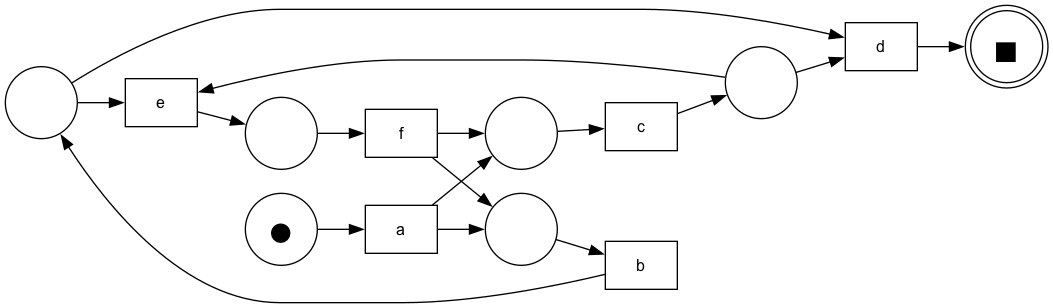

In [5]:
vizard.display(vizard.get_petri_net(net, initial_marking, final_marking))

In [6]:
missing_remaining_tokens = mock_missing_remaining_tokens(places)
missing_remaining_tokens

{'missing': defaultdict(None,
             {({'e'}, {'f'}): 5, ({'b'}, {'e', 'd'}): 5, start: 4}),
 'remaining': defaultdict(None,
             {({'a', 'f'}, {'c'}): 7, end: 9, ({'e'}, {'f'}): 9})}

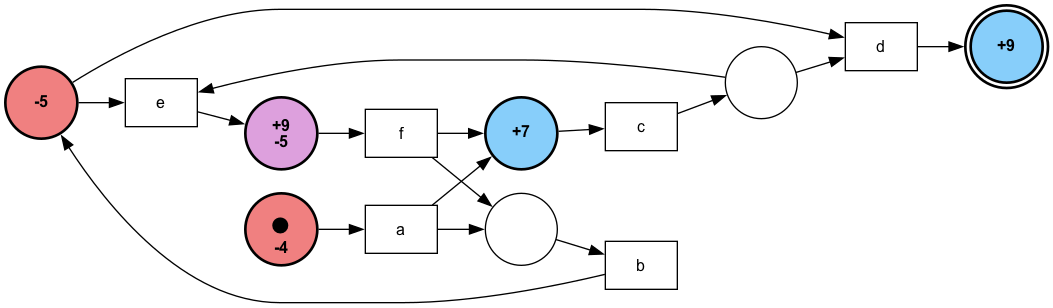

In [7]:
graph_fitness = vizard.get_petri_net(net, initial_marking, final_marking, missing_remaining_tokens)
vizard.display(graph_fitness)

### Task2 Alpha Miner

In [8]:
miner = AlphaMiner(event_log_to_csv(logs[LOG_KEY]))
graph = miner.build_and_visualize_petrinet()

net, initial_marking, final_marking = miner.get_petrinet()
places = net.places

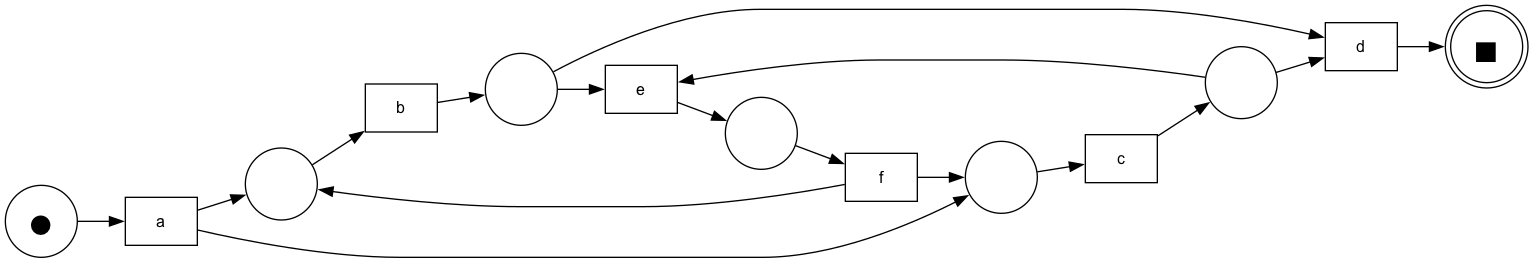

In [9]:
vizard.display(graph)

In [10]:
missing_remaining_tokens = mock_missing_remaining_tokens(places)
missing_remaining_tokens

{'missing': defaultdict(None,
             {global_start: 6,
              p({'c'}, {'e', 'd'}): 7,
              p({'b'}, {'e', 'd'}): 5}),
 'remaining': defaultdict(None,
             {global_end: 7,
              p({'a', 'f'}, {'b'}): 3,
              p({'b'}, {'e', 'd'}): 2})}

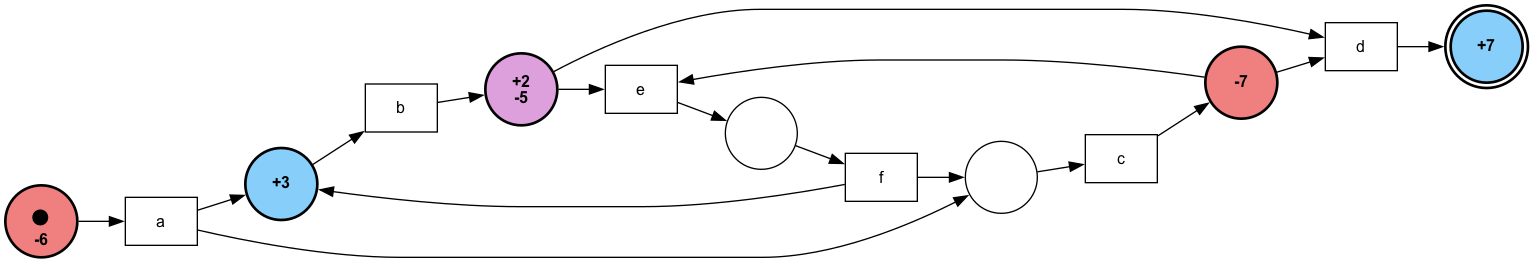

In [11]:
graph_fitness = vizard.get_petri_net(net, initial_marking, final_marking, missing_remaining_tokens)
vizard.display(graph_fitness)

### Task3 Inductive Miner

In [12]:
log = logs[LOG_KEY]
miner = InductiveMiner(log)
miner.run()
graph = miner.build_and_visualize_petrinet()

net, initial_marking, final_marking = miner.get_petrinet()
places = net.places

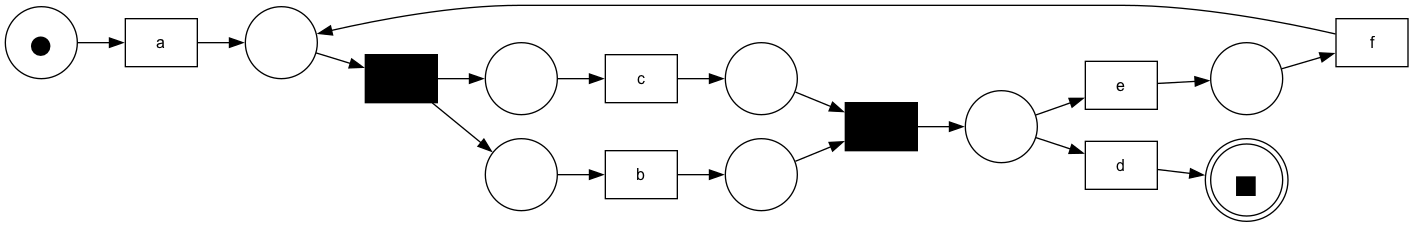

In [13]:
vizard.display(graph)

In [14]:
missing_remaining_tokens = mock_missing_remaining_tokens(places)
missing_remaining_tokens

{'missing': defaultdict(None, {p_10: 6, sink: 2, p_12: 2, p_8: 10}),
 'remaining': defaultdict(None, {p_6: 5, p_12: 5, p_10: 8, source: 4})}

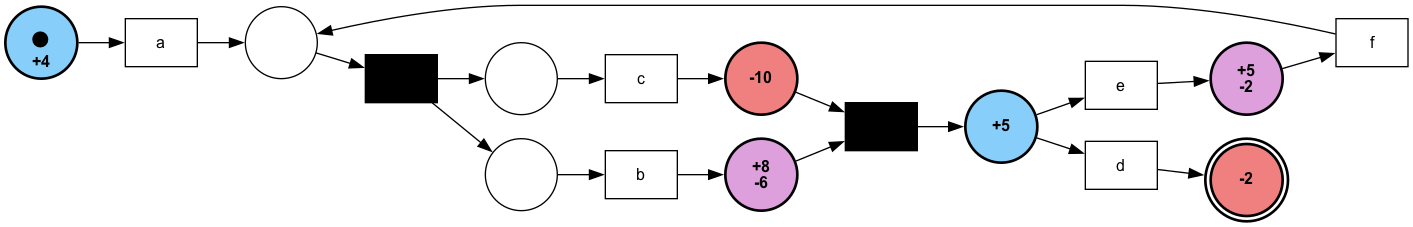

In [15]:
graph_fitness = vizard.get_petri_net(net, initial_marking, final_marking, missing_remaining_tokens)
vizard.display(graph_fitness)

In [16]:
log = logs[LOG_KEY]
miner = InductiveMinerInfrequent(log)
miner.run()
graph = miner.build_and_visualize_petrinet()

net, initial_marking, final_marking = miner.get_petrinet()
places = net.places

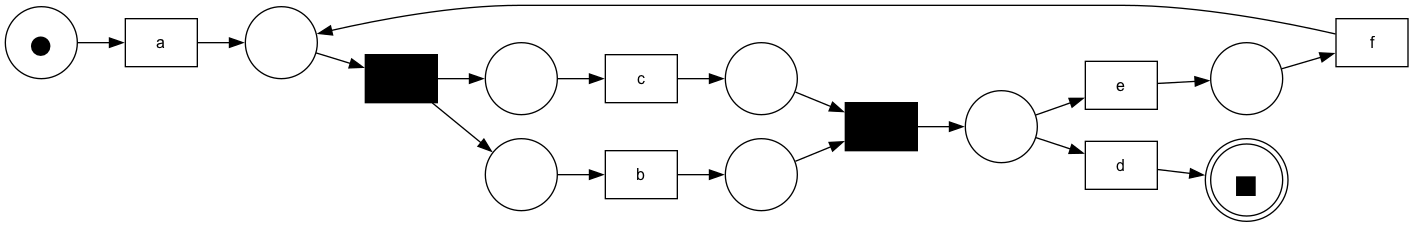

In [17]:
vizard.display(graph)

In [18]:
missing_remaining_tokens = mock_missing_remaining_tokens(places)
missing_remaining_tokens

{'missing': defaultdict(None, {p_12: 1, p_5: 10, p_9: 3, source: 1}),
 'remaining': defaultdict(None, {p_9: 9, p_12: 3, p_10: 7, source: 2})}

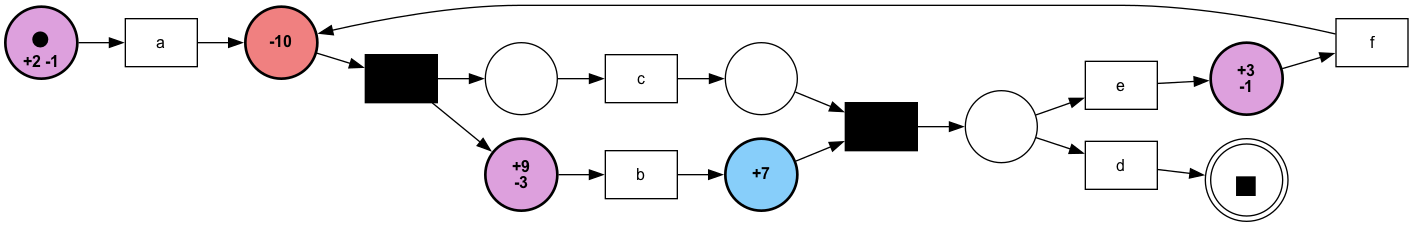

In [19]:
graph_fitness = vizard.get_petri_net(net, initial_marking, final_marking, missing_remaining_tokens)
vizard.display(graph_fitness)